**Outline**

1. Topic Review
2. Missing Data Handling in Earning Dataset
   - Handle Single Variable Missing
     - Deletion
     - Imputation
     - Multiple Imputation
   - Handle Multiple Variable Missing
     - Interative Regression Imputation

In [10]:
import numpy as np
import pandas as pd

import statsmodels.formula.api as smf
from scipy.stats import norm

import matplotlib.pyplot as plt

## Topic Review

Knowing the reason the data is missing is the key to handle missing data in order to minimizing bias.
There are four general categories of missing data mechanism:

#### **Missing Data Mechanism**
- Missingness completely at random (MCAR)
  - There's no pattern of missingness in the data. The probability of missingness is the same for all unit,
- Missingness at random (MAR)
  - The pattern of missing can be seen from the observed data. The probability of missing depend only on available information
- Missingness that depends on unobserved predictors
  - Missingness is no longer random because it depends on information that has not been recorded
- Missingness that depends on the missing value itself
  - Missingness depend on the (potentially missing) variable itself

  #### **Simple Approach**

- Discard Data / Deletion, Suitable for MCAR mechanism
  - Complete Case Analysis: also called listwise deteltion, row deletion where one or more variables are missing
  - Available Case Analysis: using subset of data to do different analysis
- Retain Data / Imputation: Fill missing value with a particular values:
  - Using central tendencies of its variable where the cases are missing
    - e.g. mean, median, modus.
    - Suitable for MCAR.
  - Using the last observed value (Last Value Carried Forward).
    - Only suitable if it make sense
    - Suitable for MAR.
  - Using information from related observations.
    - Suitable for MAR. Check the correctness of the assumption.
  - Imputation based on logical rules.
    - Suitable for MAR.
  - Simple Random Imputation
    - Using random value from the remaining observed data
    - Suitable for MCAR.
  - Deterministic Imputation using Regression
    - Using regression prediction to impute missing data
    - Suitable for MAR.
  - Random Regression Imputation
    - Using regression prediction that consider prediction error to impute missing data
    - Suitable for MAR.

    #### **Multiple Imputation**

- Imputation: Create several imputation for each missing values
- Analysis: Make inferences based on each completed dataset with different imputated values
- Pooling: Combined inferences to get final estimated parameter

Imputation helper functions

In [11]:
def impute(data, value):
    """
    Function to impute a missing data (array-like) with a certain value

    :param data: array-like, the data with missing values
    :param value: float/int, the value to use for imputing missing values
    :return imputed_array: array-like, the imputed data
    """
    # Check for each element in data
    # return True if it's a missing values (represented as NaN in numpy)
    # return False otherwise.
    bool_nan = np.isnan(data)

    # Return the value a_impute where a is missing and returns a otherwise
    imputed_data = np.where(bool_nan, value, data)

    return imputed_data

Impute Function Usage Example

In [12]:
# Create a sample array with missing values
a = np.array([1, 2, np.nan, 4, np.nan, 6])

# Impute missing values with 0
a_imputed = impute(a, 0)

print(a_imputed)

[1. 2. 0. 4. 0. 6.]


# Missing Data Handling in Earning Dataset

Social Indicator Survey (SIS) are conducted to study about the relationship between earnings and other variable such as race, sex, education and other variables. We want to build regression model, but we face the problem of some missing data in the outcome (earnings) and other variable.

- We will demonstrate how to handle missing data in three different:
  1. Discard / Delete Data (Complete Case Analysis)
  2. Imputation
     - Using logical rule
     - Using deterministic and random regression imputation
  3. Multiple Imputation using Random Regression Imputation
- Then we compare their the evaluation of regression and see which method that have best performance

### Load Data

In [13]:
SIS = pd.read_csv("social_indicator_survey.csv")

### Inspect What's Missing



In [14]:
SIS.isna().sum()

,0
earnings,241
interest,277
male,0
over65,0
white,0
immig,0
educ_r,0
workhrs_top,0
any_ssi,0
any_welfare,0


Calculate the percentage of missing

In [15]:
SIS.isna().sum()/SIS.shape[0]

,0
earnings,0.160560
interest,0.184544
male,0.000000
over65,0.000000
white,0.000000
immig,0.000000
educ_r,0.000000
workhrs_top,0.000000
any_ssi,0.000000
any_welfare,0.000000


- We have two variables that have msising data, earning and interest
- 16% data in earnings are missing, while 18% data in interest are missing
- We will discuss handle earnings variable first

## Handle Single Variable Missing

### 1. Discarding Data (Deletion): Complete Case Analysis

- The simplest way to handle missing data is discarding them
- This method is suitable is we assumed the missing of earnings and interest is completely at random (MCAR)
- We'll do complete case analyis by dropping rows that contain missing data




In [16]:
# Check the size of our original data

SIS.shape

(1501, 11)

In [17]:
# Drop all rows that contain missing data
SIS_complete_case = SIS.dropna(axis = 0)

# Check the size of data after row deletion
SIS_complete_case.shape

(1065, 11)


- We get the final complete data that has 1065 rows
- Then build the regression model and inspect the evaluation

#### Build Regression Model

- Use the data after we discard the missing value to build the model
- We do not include `interest` variable first for simplicity of comparison with other handling method, since the interest have missing data too

In [18]:
# Create OLS model object and fit the model

model_cca = smf.ols("earnings ~ male + over65 + white \
                                + immig + educ_r + workhrs_top \
                                + any_ssi + any_welfare + any_charity",
                    SIS_complete_case).fit()

#### Store Evaluation of The Model

- Store rsquared and standard error,
- We then can compare the results with other handling data methods

In [19]:
r_squared = pd.DataFrame({"rsquared_cca" : [model_cca.rsquared]})
standard_error = pd.DataFrame({"standard_error_cca" : model_cca.bse})

In [20]:
r_squared

,rsquared_cca
0,0.087366


In [21]:
standard_error

,standard_error_cca
Intercept,13.866383
male,7.737770
over65,16.735083
white,9.152745
immig,7.894987
educ_r,3.876830
workhrs_top,0.278781
any_ssi,18.852445
any_welfare,17.901944
any_charity,35.362651


- We know that other variables, sex, race, education are recorded for all the people in the survey, It's more plausible to assume we find the pattern of missingness of earnings depends only on these other, fully recorded variables.
- If we find the pattern of missingness of earnings from the observed data, then the missingness is MAR, not completely random
- The best method if we assume MAR is to retain the data to do further analysis
- We will discuss imputation in earning variable first, and then we will discuss how iterative imputation will help to impute other missing variable too
##### 2.1 Impute earnings using the logical rule

If the the respondent worked 0 hours in last year is zero, then the earning is make sense to have zero value


In [22]:
# data where `workhours` is zero

zero_earnings = (SIS['workhrs_top'] == 0)

In [23]:
# number of missing before imputation where `workhours` is zero

SIS[zero_earnings]["earnings"].isna().sum()

1

Impute earning with 0 where the `workhours` is 0

In [24]:
# impute data where workhours is zero using 0

SIS[zero_earnings] = impute(SIS[zero_earnings], 0)

In [25]:
# number of missing after imputation where workhours is zero

SIS[zero_earnings]["earnings"].isna().sum()

0

#### 2.2.1 Impute other missing earnings using regression deterministic imputation

- Make sure to build the model include all predictors that **do not contain missing data**
- For know let's exclude `interest` to predict earnings since it has missing data



In [26]:
# Exclude other variables that contain missing value
SIS_predictors = SIS.drop(columns=['interest'])



In [27]:
# Check percentage missing value
SIS_predictors.isna().sum()/SIS.shape[0]

,0
earnings,0.159893
male,0.000000
over65,0.000000
white,0.000000
immig,0.000000
educ_r,0.000000
workhrs_top,0.000000
any_ssi,0.000000
any_welfare,0.000000
any_charity,0.000000


We will only use the 84% of the data where all variables is complete

In [28]:
# Exclude earning missing cases
SIS_det = SIS_predictors.dropna(subset=['earnings'])

In [29]:
# Check percentage missing value
SIS_det.isna().sum()/SIS.shape[0]

,0
earnings,0.0
male,0.0
over65,0.0
white,0.0
immig,0.0
educ_r,0.0
workhrs_top,0.0
any_ssi,0.0
any_welfare,0.0
any_charity,0.0


In [30]:
# Create OLS model object and fit the model

model_imputation_reg = smf.ols("earnings ~ male + over65 + white \
                                            + immig + educ_r + workhrs_top \
                                            + any_ssi + any_welfare + any_charity",
                               SIS_det).fit()

- Make prediction of earning variables to impute 16% cases missing in earnings

In [31]:
# Original dataset condition where earning still contain missing value

SIS.isna().sum()

,0
earnings,240
interest,218
male,0
over65,0
white,0
immig,0
educ_r,0
workhrs_top,0
any_ssi,0
any_welfare,0


In [32]:
# Get the data where earning still missing, `SIS_predictors`

# Drop earning variable to do prediction

SIS_predictors = SIS_predictors.drop(columns=["earnings"])

In [33]:
# Do Prediction

pred_earning_det = model_imputation_reg.predict(SIS_predictors)

- Imputation using the result of prediction

In [34]:
# Impute earning variables
# Store the complete earnings that imuputed by deterministic value from regression prediction in new variable

SIS["imp_earnings_det_reg"] = impute(SIS['earnings'], pred_earning_det)


In [35]:
# Check total missing data where earnings are imputed and stored in `imp_earnings_det_reg`

SIS.isna().sum()

,0
earnings,240
interest,218
male,0
over65,0
white,0
immig,0
educ_r,0
workhrs_top,0
any_ssi,0
any_welfare,0


- `imp_earnings_det_reg` has 0 missing data
- Then build the regression model and inspect the evaluation
##### Build Regression Model

- Use the data after we discard the missing value to build the model
- Exclude `interest` to predict earnings since it has missing data

In [36]:
# Create OLS model object and fit the model

model_det_reg = smf.ols("imp_earnings_det_reg ~ male + over65 + white \
                                                + immig + educ_r + workhrs_top \
                                                + any_ssi + any_welfare + any_charity",
                        SIS).fit()

##### Store Evaluation of The Model

- Store R-squared and standard error,
- We then can compare the results with other handling data methods

In [40]:
rsquared = {}
standard_error = {}

# Assign R-squared and standard error to the dictionaries
rsquared["rsquared_det_reg"] = model_det_reg.rsquared
standard_error["standard_error_det_reg"] = model_det_reg.bse

# Print the results
print("R-squared:", rsquared["rsquared_det_reg"])
print("Standard Error:", standard_error["standard_error_det_reg"])

R-squared: 0.11274716055687906
Standard Error: Intercept      10.953386
male            5.858135
over65         12.277652
white           6.649477
immig           6.043541
educ_r          2.881293
workhrs_top     0.218081
any_ssi        15.600238
any_welfare    14.857268
any_charity    28.370762
dtype: float64


In [41]:
rsquared

{'rsquared_det_reg': 0.11274716055687906}

In [42]:
standard_error

{'standard_error_det_reg': Intercept      10.953386
 male            5.858135
 over65         12.277652
 white           6.649477
 immig           6.043541
 educ_r          2.881293
 workhrs_top     0.218081
 any_ssi        15.600238
 any_welfare    14.857268
 any_charity    28.370762
 dtype: float64}

#### 2.2.2 Impute other missing earnings using random regression imputation

- We will try to do random regression imputation too
- To do it we store the residual standard deviation from the latest model



In [43]:
# residual standard deviation
sigma = np.sqrt(model_imputation_reg.mse_resid)

print(f"estimated residual standard deviation from the model: {np.round(sigma,1)}")

estimated residual standard deviation from the model: 118.2


Store each random prediction error from normal distribution

In [44]:
np.random.seed(1)

error = np.random.normal(0, sigma, len(SIS_predictors))

Do the prediction and add the prediction error

In [45]:
# Prediction results
pred_earnings_rand_reg = model_imputation_reg.predict(SIS_predictors) + error

# Impute missing earning with prediction results
SIS["imp_earnings_rand_reg"] = impute(SIS['earnings'], pred_earnings_rand_reg)

In [46]:
# Check total missing data where earnings are imputed and stored in `imp_earnings_rand_reg`

SIS.isna().sum()

,0
earnings,240
interest,218
male,0
over65,0
white,0
immig,0
educ_r,0
workhrs_top,0
any_ssi,0
any_welfare,0


##### Build Regression Model
Use `imp_earnings_rand_reg` as the outcome

In [47]:
# Create OLS model object and fit the model

model_random_reg = smf.ols("imp_earnings_rand_reg ~ male + over65 + white \
                                                    + immig + educ_r + workhrs_top \
                                                    + any_ssi + any_welfare + any_charity",
                           SIS).fit()


##### Store Evaluation of The Model

- Store R-squared and standard error,
- We then can compare the results with other handling data methods

In [48]:
rsquared["rsquared_random_reg"] = model_random_reg.rsquared
standard_error["standard_error_random_reg"] = model_random_reg.bse

#### Performance and Standard Error Comparison


In [49]:
rsquared

{'rsquared_det_reg': 0.11274716055687906,
 'rsquared_random_reg': 0.09543339992499122}

- Rsquared from the model that use complete case analysis have lowest R-squared
- the R-squared of the model where earnings is imputed by random regression have higher R-squared than the model where the earnings is imputed by regression deterministic imputation


In [50]:
standard_error

{'standard_error_det_reg': Intercept      10.953386
 male            5.858135
 over65         12.277652
 white           6.649477
 immig           6.043541
 educ_r          2.881293
 workhrs_top     0.218081
 any_ssi        15.600238
 any_welfare    14.857268
 any_charity    28.370762
 dtype: float64,
 'standard_error_random_reg': Intercept      11.982212
 male            6.408376
 over65         13.430863
 white           7.274048
 immig           6.611197
 educ_r          3.151926
 workhrs_top     0.238565
 any_ssi        17.065532
 any_welfare    16.252777
 any_charity    31.035563
 dtype: float64}

- The standard error of the model that used complete case analysis (CCA) have highest standard error compared to other
- The standard error of the model where earnings is imputed by random regression have higher standard error than the model where the earnings is imputed by regression deterministic imputation
#### Distribution of Missing Data after Imputation
Here's the difference of the imputed values between the deterministic imputation and random imputation using regression

In [51]:
SIS[SIS["earnings"].isna()][["earnings","imp_earnings_det_reg","imp_earnings_rand_reg"]]

,earnings,imp_earnings_det_reg,imp_earnings_rand_reg
1,NaN,79.703363,7.400775
12,NaN,72.645217,34.539203
32,NaN,38.578614,-42.637314
47,NaN,91.779735,340.005791
51,NaN,111.410717,69.778827
...,...,...,...
1482,NaN,77.663442,172.913147
1490,NaN,36.245053,-155.178482
1493,NaN,20.395288,2.792144
1495,NaN,92.239886,115.481103


It's more clear if we compare the histograms of data and imputations

1. Observed earnings

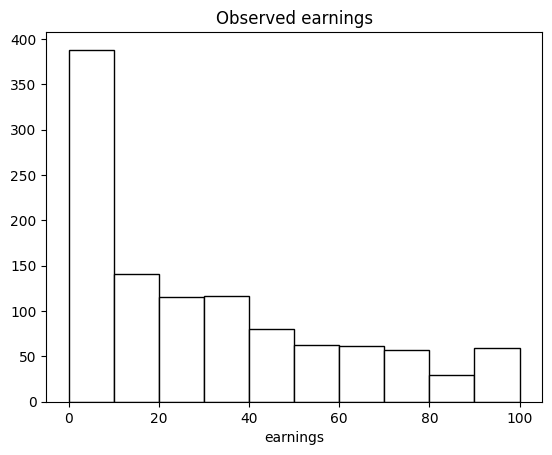

In [52]:
plt.hist(SIS[SIS["earnings"].notna()]["earnings"], bins = np.arange(0, 101, 10), color='white', edgecolor='black')
plt.xlabel('earnings')
plt.title('Observed earnings')
plt.show()

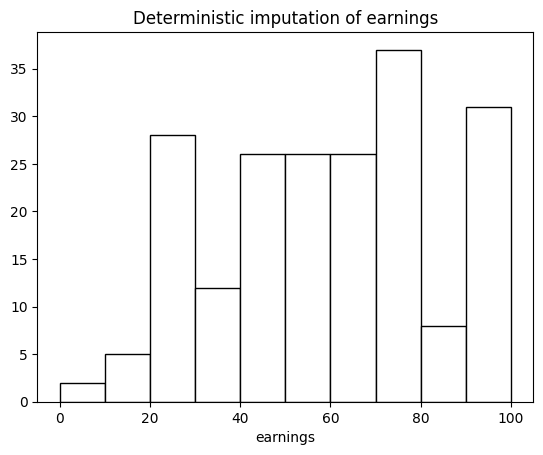

In [53]:
plt.hist(SIS[SIS["earnings"].isnull()]["imp_earnings_det_reg"], bins = np.arange(0, 101, 10), color='white', edgecolor='black')
plt.xlabel('earnings')
plt.title('Deterministic imputation of earnings')
plt.show()

3. The result of random imputation of earnings using regression

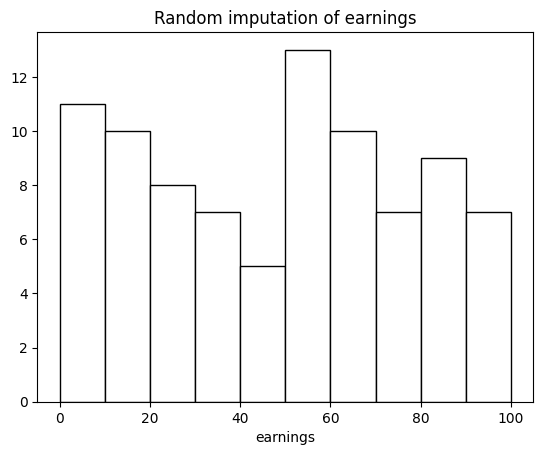

In [54]:
plt.hist(SIS[SIS["earnings"].isnull()]["imp_earnings_rand_reg"], bins = np.arange(0, 101, 10), color='white', edgecolor='black')
plt.xlabel('earnings')
plt.title('Random imputation of earnings')
plt.show()

Random regression imputation give more spread of imputed values that deterministic imputation
### 3. Multiple Imputation

#### 3.1 Imputation

##### Impute missing earnings using random regression imputation
- We use random regression imputation as the imputation model to impute a single value with 5 different values

In [55]:
# residual standard deviation as standard deviation of prediction error
sigma = np.sqrt(model_imputation_reg.mse_resid)

print(f"estimated residual standard deviation from the model: {np.round(sigma,1)}")

estimated residual standard deviation from the model: 118.2


In [56]:
data = SIS_predictors.copy()
M = 5

# Store each prediction from regression
prediction_mi = model_imputation_reg.predict(SIS_predictors)

# Create multiple m values for each missing earnings
for i in range(M):

    # the random normal distributed error will extracted in each iteration
    error = np.random.normal(0, sigma, len(data))

    # store prediction with additional error
    pred_i_earnings = prediction_mi + error

    # impute missing earning with regression prediction that taking account the error
    SIS[f"imp_{i+1}_earnings_MI"] = impute(SIS['earnings'], pred_i_earnings)

The original earnings variabel and m imputed values

In [57]:
SIS[ ["earnings"] + [f"imp_{i+1}_earnings_MI" for i in range(M)] ]

,earnings,imp_1_earnings_MI,imp_2_earnings_MI,imp_3_earnings_MI,imp_4_earnings_MI,imp_5_earnings_MI
0,84.0,84.000000,84.000000,84.000000,84.000000,84.000000
1,NaN,47.647241,249.038732,36.108998,109.497844,-19.090609
2,27.5,27.500000,27.500000,27.500000,27.500000,27.500000
3,85.0,85.000000,85.000000,85.000000,85.000000,85.000000
4,135.0,135.000000,135.000000,135.000000,135.000000,135.000000
...,...,...,...,...,...,...
1496,21.6,21.600000,21.600000,21.600000,21.600000,21.600000
1497,NaN,-122.163440,50.022594,-293.660504,-4.272014,-13.819583
1498,510.0,510.000000,510.000000,510.000000,510.000000,510.000000
1499,26.4,26.400000,26.400000,26.400000,26.400000,26.400000


In [64]:
# Create m OLS model object and fit the model

model_mi = []
for i in range(M):

    # Define model
    formula_i = f"imp_{i+1}_earnings_MI ~ male + over65 + white \
                                          + immig + educ_r + workhrs_top \
                                          + any_ssi + any_welfare + any_charity"
    model_i = smf.ols(formula = formula_i,
                      data = SIS).fit()

    # Append model_i to model_mi
    model_mi.append(model_i)

- We have different values to impute each missing earnings

#### 3.2 Analysis

Next, in analysis phase, we build different regression model from each different imputed earnings variable

##### Build Regression Model

Use different imputated earning, `imp_i_earnings_MI` variable as the outcome


We have 5 different model


In [65]:
model_mi

and 5 different coefficient

In [66]:
arr_coeff = [np.array(model_mi[i].params) for i in range(M)]

coeff_model = pd.DataFrame(data = np.array(arr_coeff).T,
                           columns = [f"coef{i+1}" for i in range(M)],
                           index = model_mi[0].params.index)
coeff_model

,coef1,coef2,coef3,coef4,coef5
Intercept,-36.272338,-43.767360,-36.302509,-39.591396,-35.629805
male,2.201745,-2.395131,-2.105514,-3.176932,-3.572320
over65,-12.401171,-11.030887,-10.605514,-11.328853,-11.444771
white,19.934826,23.416587,20.566330,20.684861,21.646382
immig,-9.618461,-10.458283,-15.370881,-14.020093,-17.175391
educ_r,17.388079,20.069315,17.532137,19.409653,18.011644
workhrs_top,1.383394,1.420696,1.403587,1.369056,1.465824
any_ssi,3.703093,-2.460571,0.873456,5.850938,1.385297
any_welfare,-20.311798,-4.322554,-6.915295,-14.676486,-13.611369
any_charity,-24.665233,-32.770035,-16.121281,-24.543460,-20.677413


In [67]:
arr_se_coeff = [np.array(model_mi[i].bse) for i in range(M)]

se_coeff_model = pd.DataFrame(data = np.array(arr_se_coeff).T,
                              columns = [f"se_coeff_{i+1}" for i in range(M)],
                              index = model_mi[0].bse.index)
se_coeff_model

,se_coeff_1,se_coeff_2,se_coeff_3,se_coeff_4,se_coeff_5
Intercept,11.924837,12.005391,11.900320,11.964391,11.979736
male,6.377691,6.420773,6.364578,6.398845,6.407052
over65,13.366552,13.456845,13.339070,13.410887,13.428088
white,7.239217,7.288119,7.224333,7.263229,7.272544
immig,6.579540,6.623986,6.566013,6.601364,6.609831
educ_r,3.136834,3.158024,3.130384,3.147238,3.151275
workhrs_top,0.237423,0.239027,0.236935,0.238210,0.238516
any_ssi,16.983817,17.098545,16.948898,17.040150,17.062005
any_welfare,16.174953,16.284218,16.141698,16.228604,16.249418
any_charity,30.886954,31.095600,30.823450,30.989403,31.029149


In [68]:
coeff_model["final_coef"] = np.mean(coeff_model, axis=1)
coeff_model

,coef1,coef2,coef3,coef4,coef5,final_coef
Intercept,-36.272338,-43.767360,-36.302509,-39.591396,-35.629805,-38.312682
male,2.201745,-2.395131,-2.105514,-3.176932,-3.572320,-1.809630
over65,-12.401171,-11.030887,-10.605514,-11.328853,-11.444771,-11.362239
white,19.934826,23.416587,20.566330,20.684861,21.646382,21.249797
immig,-9.618461,-10.458283,-15.370881,-14.020093,-17.175391,-13.328622
educ_r,17.388079,20.069315,17.532137,19.409653,18.011644,18.482166
workhrs_top,1.383394,1.420696,1.403587,1.369056,1.465824,1.408511
any_ssi,3.703093,-2.460571,0.873456,5.850938,1.385297,1.870442
any_welfare,-20.311798,-4.322554,-6.915295,-14.676486,-13.611369,-11.967500
any_charity,-24.665233,-32.770035,-16.121281,-24.543460,-20.677413,-23.755485


In [69]:
# Calculate W as the evarage of m standard error in each coefficient

se_coeff_model["W"] = np.mean(se_coeff_model**2, axis=1)
se_coeff_model

,se_coeff_1,se_coeff_2,se_coeff_3,se_coeff_4,se_coeff_5,W
Intercept,11.924837,12.005391,11.900320,11.964391,11.979736,142.921898
male,6.377691,6.420773,6.364578,6.398845,6.407052,40.880930
over65,13.366552,13.456845,13.339070,13.410887,13.428088,179.569524
white,7.239217,7.288119,7.224333,7.263229,7.272544,52.671665
immig,6.579540,6.623986,6.566013,6.601364,6.609831,43.509588
educ_r,3.136834,3.158024,3.130384,3.147238,3.151275,9.889557
workhrs_top,0.237423,0.239027,0.236935,0.238210,0.238516,0.056655
any_ssi,16.983817,17.098545,16.948898,17.040150,17.062005,289.910827
any_welfare,16.174953,16.284218,16.141698,16.228604,16.249418,262.954088
any_charity,30.886954,31.095600,30.823450,30.989403,31.029149,958.835303


In [70]:
# calculate the squared difference each M estimated coefficient to its mean (final coefficient)

list_demeaned = []
for i in range(M):
    list_demeaned.append( (coeff_model[f"coef{i+1}"] - coeff_model["final_coef"])**2 )

In [72]:
demeaned = pd.DataFrame(data = np.array(list_demeaned).T,
                        columns = [f"demeaned_coeff_{i+1}" for i in range(M)],
                        index = coeff_model.index)
demeaned

,demeaned_coeff_1,demeaned_coeff_2,demeaned_coeff_3,demeaned_coeff_4,demeaned_coeff_5
Intercept,4.163001,29.753517,4.040795,1.635111,7.197829
male,16.091133,0.342810,0.087547,1.869514,3.107074
over65,1.079379,0.109794,0.572633,0.001115,0.006811
white,1.729149,4.694977,0.467127,0.319153,0.157280
immig,13.765293,8.238847,4.170824,0.478132,14.797634
educ_r,1.197025,2.519045,0.902554,0.860232,0.221391
workhrs_top,0.000631,0.000148,0.000024,0.001557,0.003285
any_ssi,3.358610,18.757682,0.993982,15.844341,0.235366
any_welfare,69.627301,58.445200,25.524784,7.338603,2.702305
any_charity,0.827643,81.262126,58.281059,0.620905,9.474525


In [73]:
# Sum all the squared difference

demeaned["sum"] = demeaned.sum(axis=1)
demeaned

,demeaned_coeff_1,demeaned_coeff_2,demeaned_coeff_3,demeaned_coeff_4,demeaned_coeff_5,sum
Intercept,4.163001,29.753517,4.040795,1.635111,7.197829,46.790253
male,16.091133,0.342810,0.087547,1.869514,3.107074,21.498080
over65,1.079379,0.109794,0.572633,0.001115,0.006811,1.769733
white,1.729149,4.694977,0.467127,0.319153,0.157280,7.367685
immig,13.765293,8.238847,4.170824,0.478132,14.797634,41.450730
educ_r,1.197025,2.519045,0.902554,0.860232,0.221391,5.700247
workhrs_top,0.000631,0.000148,0.000024,0.001557,0.003285,0.005645
any_ssi,3.358610,18.757682,0.993982,15.844341,0.235366,39.189980
any_welfare,69.627301,58.445200,25.524784,7.338603,2.702305,163.638192
any_charity,0.827643,81.262126,58.281059,0.620905,9.474525,150.466259


In [74]:
# Divide by M-1

demeaned["B"] = demeaned["sum"]/(M-1)
demeaned

,demeaned_coeff_1,demeaned_coeff_2,demeaned_coeff_3,demeaned_coeff_4,demeaned_coeff_5,sum,B
Intercept,4.163001,29.753517,4.040795,1.635111,7.197829,46.790253,11.697563
male,16.091133,0.342810,0.087547,1.869514,3.107074,21.498080,5.374520
over65,1.079379,0.109794,0.572633,0.001115,0.006811,1.769733,0.442433
white,1.729149,4.694977,0.467127,0.319153,0.157280,7.367685,1.841921
immig,13.765293,8.238847,4.170824,0.478132,14.797634,41.450730,10.362682
educ_r,1.197025,2.519045,0.902554,0.860232,0.221391,5.700247,1.425062
workhrs_top,0.000631,0.000148,0.000024,0.001557,0.003285,0.005645,0.001411
any_ssi,3.358610,18.757682,0.993982,15.844341,0.235366,39.189980,9.797495
any_welfare,69.627301,58.445200,25.524784,7.338603,2.702305,163.638192,40.909548
any_charity,0.827643,81.262126,58.281059,0.620905,9.474525,150.466259,37.616565


In [75]:
se_coeff_model["B"] = demeaned["B"].copy()

In [76]:
se_coeff_model

,se_coeff_1,se_coeff_2,se_coeff_3,se_coeff_4,se_coeff_5,W,B
Intercept,11.924837,12.005391,11.900320,11.964391,11.979736,142.921898,11.697563
male,6.377691,6.420773,6.364578,6.398845,6.407052,40.880930,5.374520
over65,13.366552,13.456845,13.339070,13.410887,13.428088,179.569524,0.442433
white,7.239217,7.288119,7.224333,7.263229,7.272544,52.671665,1.841921
immig,6.579540,6.623986,6.566013,6.601364,6.609831,43.509588,10.362682
educ_r,3.136834,3.158024,3.130384,3.147238,3.151275,9.889557,1.425062
workhrs_top,0.237423,0.239027,0.236935,0.238210,0.238516,0.056655,0.001411
any_ssi,16.983817,17.098545,16.948898,17.040150,17.062005,289.910827,9.797495
any_welfare,16.174953,16.284218,16.141698,16.228604,16.249418,262.954088,40.909548
any_charity,30.886954,31.095600,30.823450,30.989403,31.029149,958.835303,37.616565



$$\text{SE}(\beta) = \sqrt{(W+\left ( 1+\frac{1}{M} \right )B)}$$

In [77]:
# Calculate the final standard error of each variable given W and B
se_coeff_model["final_se"] = np.sqrt( se_coeff_model["W"] + ( (1 + (1/M) ) * se_coeff_model["B"] ) )
se_coeff_model

,se_coeff_1,se_coeff_2,se_coeff_3,se_coeff_4,se_coeff_5,W,B,final_se
Intercept,11.924837,12.005391,11.900320,11.964391,11.979736,142.921898,11.697563,12.528327
male,6.377691,6.420773,6.364578,6.398845,6.407052,40.880930,5.374520,6.879706
over65,13.366552,13.456845,13.339070,13.410887,13.428088,179.569524,0.442433,13.420151
white,7.239217,7.288119,7.224333,7.263229,7.272544,52.671665,1.841921,7.408237
immig,6.579540,6.623986,6.566013,6.601364,6.609831,43.509588,10.362682,7.479626
educ_r,3.136834,3.158024,3.130384,3.147238,3.151275,9.889557,1.425062,3.405823
workhrs_top,0.237423,0.239027,0.236935,0.238210,0.238516,0.056655,0.001411,0.241555
any_ssi,16.983817,17.098545,16.948898,17.040150,17.062005,289.910827,9.797495,17.368587
any_welfare,16.174953,16.284218,16.141698,16.228604,16.249418,262.954088,40.909548,17.664811
any_charity,30.886954,31.095600,30.823450,30.989403,31.029149,958.835303,37.616565,31.685567


In [78]:
pooling = pd.concat([coeff_model["final_coef"], se_coeff_model["final_se"]], axis=1)
pooling

,final_coef,final_se
Intercept,-38.312682,12.528327
male,-1.809630,6.879706
over65,-11.362239,13.420151
white,21.249797,7.408237
immig,-13.328622,7.479626
educ_r,18.482166,3.405823
workhrs_top,1.408511,0.241555
any_ssi,1.870442,17.368587
any_welfare,-11.967500,17.664811
any_charity,-23.755485,31.685567


#### Standard Error Comparison

In [90]:
standard_error["standard_error_mi"] = pooling["final_se"]
standard_error

{'standard_error_det_reg': Intercept      10.953386
 male            5.858135
 over65         12.277652
 white           6.649477
 immig           6.043541
 educ_r          2.881293
 workhrs_top     0.218081
 any_ssi        15.600238
 any_welfare    14.857268
 any_charity    28.370762
 dtype: float64,
 'standard_error_random_reg': Intercept      11.982212
 male            6.408376
 over65         13.430863
 white           7.274048
 immig           6.611197
 educ_r          3.151926
 workhrs_top     0.238565
 any_ssi        17.065532
 any_welfare    16.252777
 any_charity    31.035563
 dtype: float64,
 'standard_error_mi': Intercept      12.528327
 male            6.879706
 over65         13.420151
 white           7.408237
 immig           7.479626
 educ_r          3.405823
 workhrs_top     0.241555
 any_ssi        17.368587
 any_welfare    17.664811
 any_charity    31.685567
 Name: final_se, dtype: float64}

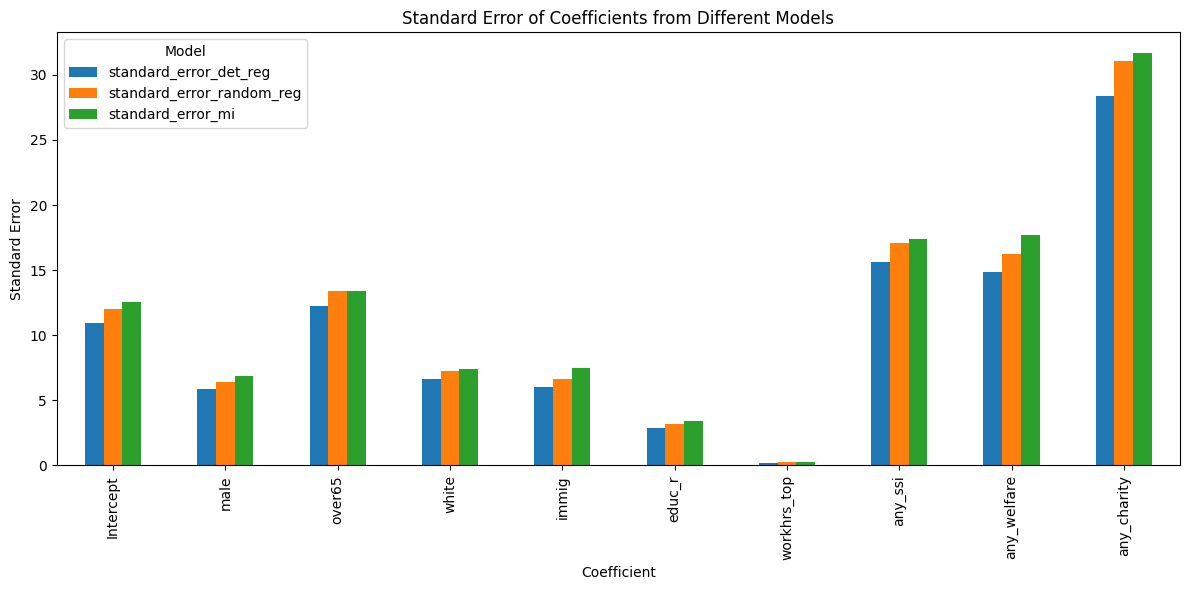

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# Standard error data
standard_error = {
    'standard_error_det_reg': pd.Series({
        "Intercept": 10.953386,
        "male": 5.858135,
        "over65": 12.277652,
        "white": 6.649477,
        "immig": 6.043541,
        "educ_r": 2.881293,
        "workhrs_top": 0.218081,
        "any_ssi": 15.600238,
        "any_welfare": 14.857268,
        "any_charity": 28.370762
    }),
    'standard_error_random_reg': pd.Series({
        "Intercept": 11.982212,
        "male": 6.408376,
        "over65": 13.430863,
        "white": 7.274048,
        "immig": 6.611197,
        "educ_r": 3.151926,
        "workhrs_top": 0.238565,
        "any_ssi": 17.065532,
        "any_welfare": 16.252777,
        "any_charity": 31.035563
    }),
    'standard_error_mi': pd.Series({
        "Intercept": 12.528327,
        "male": 6.879706,
        "over65": 13.420151,
        "white": 7.408237,
        "immig": 7.479626,
        "educ_r": 3.405823,
        "workhrs_top": 0.241555,
        "any_ssi": 17.368587,
        "any_welfare": 17.664811,
        "any_charity": 31.685567
    })
}

# Convert dictionary to DataFrame
standard_error_df = pd.DataFrame(standard_error)

# Plot as a grouped bar chart
standard_error_df.plot(kind="bar", figsize=(12, 6))
plt.title("Standard Error of Coefficients from Different Models")
plt.xlabel("Coefficient")
plt.ylabel("Standard Error")
plt.legend(title="Model", loc="upper left")
plt.tight_layout()
plt.show()


**Conclusion**

- Generally the handling method that achive the smallest to highest standard error across all coefficient is
  1. Deterministic Imputation using Regression
  2. Random Imputation using Regression
  3. Multiple Imputation
  4. Complete Case Analysis

  - Surprisingly the deterministic imputation using regression have smallest standard error than complete case analysis, random regression imputation, and multiple imputation
- As we expect the complete case analysis have highest standard error since the amount of sample size is smaller than the dataset that imputed
- Multiple Imputation results depends on the model that we use to impute missing data, it might need other alternative models achived higher standard error
- However, in our data, simple approches of imputation using deterministic regression is the best method sofat by achieving smalest standard error

## Handle Multiple Variable Missing

### Iterative regression imputation

- So far, we are handling **only earnings** variable and compare the evaluation of deletion method and imputation method where we exclude `interest` variable
- We will discuss iterative regression to demonstrate imputation if we have more than 1 predictors that contain missing data `interest`.
Interative regression imputation is a method that **iteratively impute each missing value in a variables, using other fully observed predictor**.

What happened if there's overalapping cases that missing in more than 1 variable?

In [93]:
missing_earnings_interest = (SIS["earnings"].isna() & SIS["interest"].isna())

SIS[missing_earnings_interest]

,earnings,interest,male,over65,white,immig,educ_r,workhrs_top,any_ssi,any_welfare,any_charity,imp_earnings_det_reg,imp_earnings_rand_reg,imp_1_earnings_MI,imp_2_earnings_MI,imp_3_earnings_MI,imp_4_earnings_MI,imp_5_earnings_MI
47,NaN,NaN,0,0,0,0,4.0,40,0,0,0,91.779735,340.005791,101.080232,-32.835295,-58.153020,297.698937,178.299959
57,NaN,NaN,0,0,1,0,4.0,20,0,0,0,83.178132,193.223713,276.548164,310.305531,164.533968,28.640058,255.585292
106,NaN,NaN,0,0,0,0,3.0,40,0,0,0,73.102686,160.627961,103.683080,217.318981,197.242282,172.112574,113.909303
134,NaN,NaN,1,0,0,0,4.0,40,0,0,0,91.285952,184.986626,21.947056,55.115950,223.936600,216.444546,-151.569186
142,NaN,NaN,0,0,1,0,2.0,40,0,0,0,74.056620,176.748993,-60.256732,262.042174,221.462770,102.329061,258.355855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,NaN,NaN,1,0,1,0,4.0,40,0,0,0,110.916934,125.964063,7.556280,230.964532,-67.101116,380.407486,300.067353
1377,NaN,NaN,0,0,0,1,3.0,40,0,0,0,61.026315,-5.651388,-57.725332,-30.500546,-162.276674,159.010045,266.828525
1384,NaN,NaN,0,0,1,0,4.0,35,0,0,0,104.352571,33.379849,105.254048,141.587768,49.659440,32.604094,219.077712
1482,NaN,NaN,0,0,0,0,4.0,30,0,0,0,77.663442,172.913147,101.973526,16.529902,86.174217,55.532456,300.706111


#### Starting Value Imputation: Simple Random Imputation

We can initiate a starting value using crude approach e.g. simple random imputation as the initial imputed values of our missing data
Helper function to do simple random imputation

In [94]:
def random_imp(a):

    # Array containin boolearn, True if the element in a is missing, False otherwise
    missing = np.isnan(a)

    # Number of missing value
    n_missing = sum(missing)

    # a observation that's not missing
    a_obs = a[~missing]

    # Copy of a
    imputed = a.copy()

    # Impute missing value with random observation that's not missing
    imputed[missing] = np.random.choice(a_obs, size=n_missing)

    return imputed

Do simple random imputation in both earning and interest variable

In [95]:
SIS['interest_imp'] = random_imp(SIS['interest'])
SIS['earnings_imp'] = random_imp(SIS['earnings'])

We have two new variables that impute missing earnings and interest with random value from remaining observed data

In [96]:
init_sis = SIS[missing_earnings_interest][["earnings","interest","earnings_imp","interest_imp"]].copy()
init_sis

,earnings,interest,earnings_imp,interest_imp
47,NaN,NaN,40.0,0.00
57,NaN,NaN,40.0,0.00
106,NaN,NaN,46.0,0.13
134,NaN,NaN,0.0,0.10
142,NaN,NaN,30.0,0.00
...,...,...,...,...
1338,NaN,NaN,40.0,0.00
1377,NaN,NaN,60.0,0.00
1384,NaN,NaN,100.0,0.10
1482,NaN,NaN,31.0,0.00


#### Iterative Imputation
- Next, impute earning variable first using regression prediction with other complete predictors and `interest_imp` where it has complete case with simple random imputation
- After we have earning variable imputed, we will impute `interest` variable using regression prediction, with *updated values of earnings* after being imputed
- Repeat those step untill it converge, for simplicity we just use n = 10 iteration


In [97]:
# initiate n iteration
n_loop = 10

# iteration
for s in range(n_loop):

    # build regression model predict the missing earning
    model = smf.ols('earnings ~ interest_imp + male + over65 + white + \
                                immig + educ_r + workhrs_top + any_ssi + any_welfare + \
                                any_charity', SIS).fit()

    # predict earnings
    SIS_predictors["interest_imp"] = SIS['interest_imp']
    pred1 = model.predict(SIS_predictors)

    # impute missing earnings with predicted earnings
    SIS['earnings_imp'] = impute(SIS["earnings"], pred1)

    # build regression model predict the missing interest
    model = smf.ols('interest ~ earnings_imp + male + over65 + white + immig + educ_r + \
                                workhrs_top + any_ssi + any_welfare + any_charity', SIS).fit()

    # predict interest
    SIS_predictors["earnings_imp"] = SIS['earnings_imp']
    pred2 = model.predict(SIS_predictors)

    # impute missing interest with predicted interest
    SIS['interest_imp'] = impute(SIS["interest"], pred2)

The above is not the most efficient code; we show it here to demonstrate the general concept of iterative imputation.

In [98]:
iterative_imputation_sis = SIS[missing_earnings_interest][["earnings","interest","earnings_imp","interest_imp"]]
iterative_imputation_sis

,earnings,interest,earnings_imp,interest_imp
47,NaN,NaN,91.770086,1.237925
57,NaN,NaN,83.155917,3.163247
106,NaN,NaN,73.107842,0.050138
134,NaN,NaN,91.247909,3.760517
142,NaN,NaN,74.071806,0.298538
...,...,...,...,...
1338,NaN,NaN,110.874116,5.196703
1377,NaN,NaN,61.031816,-0.097555
1384,NaN,NaN,104.336199,2.796395
1482,NaN,NaN,77.649898,1.482493


Compare histograms of initial condition (using simple random imputation) and after iterative imputations

**Earning**


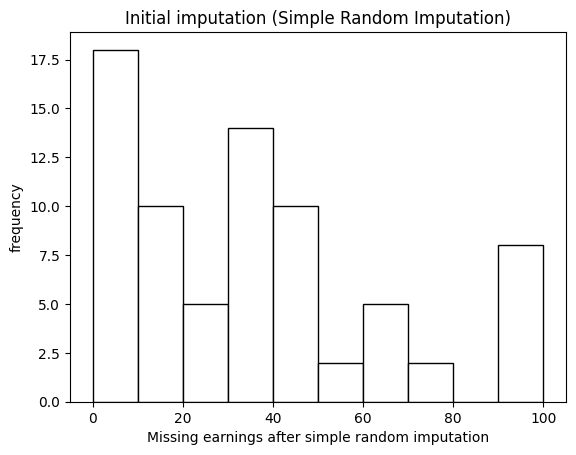

In [99]:
plt.hist(init_sis["earnings_imp"], bins = np.arange(0, 101, 10), color='white', edgecolor='black')
plt.xlabel('Missing earnings after simple random imputation')
plt.ylabel('frequency')
plt.title('Initial imputation (Simple Random Imputation)')
plt.show()

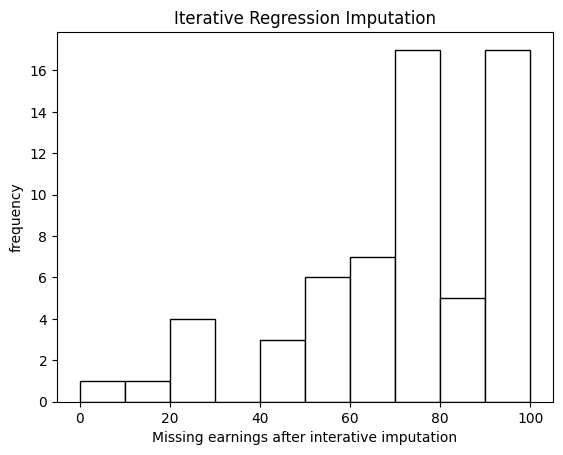

In [100]:
plt.hist(iterative_imputation_sis["earnings_imp"], bins = np.arange(0, 101, 10), color='white', edgecolor='black')
plt.xlabel('Missing earnings after interative imputation')
plt.ylabel('frequency')
plt.title('Iterative Regression Imputation')
plt.show()

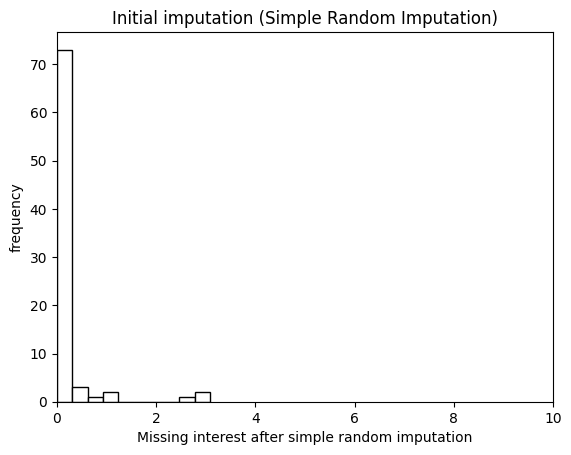

In [101]:
plt.hist(init_sis["interest_imp"], color='white', edgecolor='black')
plt.ylabel('frequency')
plt.xlabel('Missing interest after simple random imputation')
plt.title('Initial imputation (Simple Random Imputation)')
plt.xlim([0,10])
plt.show()

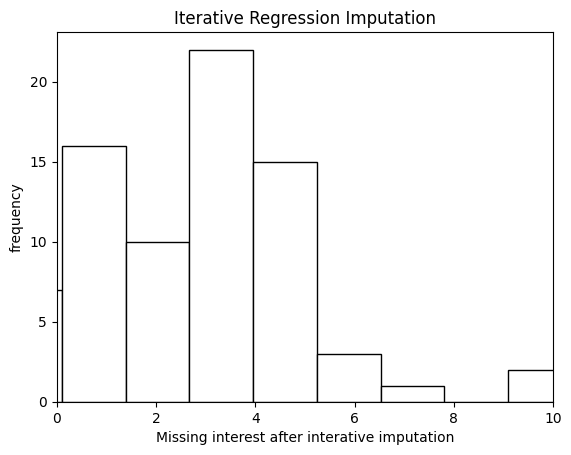

In [102]:
plt.hist(iterative_imputation_sis["interest_imp"], color='white', edgecolor='black')
plt.ylabel('frequency')
plt.xlabel('Missing interest after interative imputation')
plt.title('Iterative Regression Imputation')
plt.xlim([0,10])
plt.show()


After iterative imputation, we have final imputed dataset where it differs from the original one.

#### Performance and Standard Error Comparison

Last, let's compare the evaluation of Complete Case Analysis and Iterative Imputation where we include the `interest` variable

##### Complete Case Analysis

**Build Regression Model for CCA dataset**

In [103]:
SIS_complete_case

,earnings,interest,male,over65,white,immig,educ_r,workhrs_top,any_ssi,any_welfare,any_charity
0,84.0,0.20,1,0,1,1,4.0,40,0,0,0
2,27.5,0.16,1,0,0,1,2.0,40,0,0,0
3,85.0,5.00,1,1,1,0,4.0,8,0,0,0
4,135.0,0.10,1,0,0,0,4.0,40,0,0,0
6,92.0,1.50,0,0,1,0,4.0,40,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1491,91.0,20.00,0,0,0,0,4.0,40,0,0,0
1494,10.0,1.00,0,0,1,0,2.0,20,0,0,0
1496,21.6,0.00,1,0,0,0,2.0,40,0,0,0
1499,26.4,0.00,0,0,0,1,1.0,40,0,0,0


- Use the data after we discard the missing value to build the model
- Include `interest` variable

In [104]:
# Create OLS model object and fit the model
model_cca = smf.ols("earnings ~ male + over65 + white + immig \
                                + educ_r + interest + workhrs_top \
                                + any_ssi + any_welfare + any_charity",
                    SIS_complete_case).fit()

**Store Evaluation of The Model**

In [105]:
model_cca_rsquared = model_cca.rsquared

In [106]:
model_cca_se = model_cca.bse

##### Dataset after Iterative Regression Imputation

**Build Regression Model for Dataset after Iterative Regression Imputation**

- Use `earnings_imp` and include `interest_imp` variable

In [107]:
# Create OLS model object and fit the model
model_iter_reg = smf.ols("earnings_imp ~ male + over65 + white + immig \
                                            + educ_r + interest_imp + workhrs_top \
                                            + any_ssi + any_welfare + any_charity",
                         SIS).fit()

**Store Evaluation of The Model**

In [108]:
model_iter_reg_rsquared = model_iter_reg.rsquared

In [110]:
model_iter_reg_se = model_iter_reg.bse

##### Comparison

In [109]:
rsquared = pd.DataFrame(data = {"rsquared" : [model_cca_rsquared, model_iter_reg_rsquared]}, index = ["cca", "iterative"])
rsquared

,rsquared
cca,0.087531
iterative,0.112933


Model that use iterative regression imputation to handle missing earning and interest give higher explained variance for about 3% higher

In [111]:
arr_se = np.array([model_cca_se, model_iter_reg_se]).T

standard_error = pd.DataFrame(data = arr_se,
                              columns = ["cca", "iterative"],
                              index = model_cca.params.index)
standard_error


,cca,iterative
Intercept,13.878914,10.961377
male,7.753432,5.870064
over65,16.803567,12.308556
white,9.161024,6.653873
immig,7.898028,6.044775
educ_r,3.885855,2.886718
interest,0.158236,0.140880
workhrs_top,0.278987,0.218152
any_ssi,18.862275,15.603892
any_welfare,17.908815,14.860255


Model that use iterative regression imputation to handle missing earning and interest give smaller standard error across all coefficient

**Conclusion**

In our data, iterative regression imputation give better performance and estimate (higher R-squared and smaller Standard Error) than Complete Case Analysis